In [40]:
!export nnUNet_raw=/home/cansu/SSLCAT/SSLesion/code/nnUNet/data/nnUNet_raw
!export nnUNet_preprocessed=/home/cansu/SSLCAT/SSLesion/code/nnUNet/data/nnUNet_preprocessed
!export nnUNet_results=/home/cansu/SSLCAT/SSLesion/code/nnUNet/data/nnUNet_results
!echo ${nnUNet_raw}

In [ ]:
export nnUNet_raw=/home/cansu/SSLCAT/SSLesion/code/nnUNet/data/nnUNet_raw ; export nnUNet_preprocessed=/home/cansu/SSLCAT/SSLesion/code/nnUNet/data/nnUNet_preprocessed ; export nnUNet_results=/home/cansu/SSLCAT/SSLesion/code/nnUNet/data/nnUNet_results

In [55]:
import os
import json
import shutil

from collections import OrderedDict

dataset_name = 'Dataset100_Brats19'  # ["DatasetXXX_YYY" where XXX is a 3-digit identifier (such as 001, 002, 043, 999, ...) and YYY is the (unique) dataset name]
nnunet_basedir = "/home/cansu/SSLCAT/SSLesion/code/nnUNet"  # Main folder
nnunet_dataset = os.path.join(nnunet_basedir, 'data/nnUNet_raw/', dataset_name)  # [nnUNet_raw: is where you place the raw datasets. This folder will have one subfolder for each dataset names..]

# The tree structure of each DatasetXXX_YYY folder includes 'imageTr', 'labelsTr' and optionally 'imagesTs'
train_image_dir = os.path.join(nnunet_dataset,'imagesTr')
train_label_dir = os.path.join(nnunet_dataset,'labelsTr')
test_dir = os.path.join(nnunet_dataset,'imagesTs')
test_label_dir = os.path.join(nnunet_dataset,'labelsTs')
# ----------------------------------------------------------------------------------------

os.makedirs(train_image_dir, exist_ok = True)
os.makedirs(train_label_dir, exist_ok = True)
os.makedirs(test_dir, exist_ok = True)
os.makedirs(test_label_dir, exist_ok = True)

Conversion from h5 numpy array images to .nii.gz images 

In [57]:
import os 
import h5py
import nibabel as nib
import numpy as np
import SimpleITK as sitk

path_h5 = "/home/cansu/SSLCAT/SSLesion/data/BraTS2019/data"
train_txt = "/home/cansu/SSLCAT/SSLesion/data/BraTS2019/train.txt"
test_txt = "/home/cansu/SSLCAT/SSLesion/data/BraTS2019/test.txt"
val_txt = "/home/cansu/SSLCAT/SSLesion/data/BraTS2019/val.txt"

# read the train, test, and validation text files
with open(train_txt, 'r') as f:
    train_cases = [line.strip() for line in f.readlines()]
with open(test_txt, 'r') as f:
    test_cases = [line.strip() for line in f.readlines()]
with open(val_txt, 'r') as f:
    val_cases = [line.strip() for line in f.readlines()]

combined_cases = train_cases + val_cases

# For the training and val set 
dict_names_t = {}
dict_names_v = {}
case_id = 0
for org_id in combined_cases:
    patient_id = str(case_id).zfill(3)

    orig_img_path = os.path.join(path_h5, f"{org_id}.h5")

    # read h5 image
    with h5py.File(orig_img_path, 'r') as f:
        image_data = f['image'][:]
        label_data = f['label'][:]

    # create nifti images  using SimpleITK
    image_nifti = sitk.GetImageFromArray(image_data)
    label_nifti = sitk.GetImageFromArray(label_data)
    # Set the origin, spacing, and direction
    image_nifti.SetOrigin((0.0, 0.0, 0.0))
    image_nifti.SetSpacing((1.0, 1.0, 1.0))
    label_nifti.SetOrigin((0.0, 0.0, 0.0))
    label_nifti.SetSpacing((1.0, 1.0, 1.0))

    # Define the destination paths
    dest_image_path = os.path.join(train_image_dir, f"brats19_{patient_id}_0000.nii.gz")
    dest_label_path = os.path.join(train_label_dir, f"brats19_{patient_id}.nii.gz")

    # Save the Nifti images using SimpleITK
    sitk.WriteImage(image_nifti, dest_image_path)
    sitk.WriteImage(label_nifti, dest_label_path)

    # if the org_id is in the validation set, save it to the validation dictionary
    if org_id in val_cases:
        dict_names_v[f"brats19_{patient_id}_0000"] = org_id  # Store the mapping of case ID to patient ID
    else:
        dict_names_t[f"brats19_{patient_id}_0000"] = org_id  # Store the mapping of case ID to patient ID

    case_id += 1

# save the dictionary to a JSON file
json_path = os.path.join(nnunet_dataset, 'dict_names_train.json')
with open(json_path, 'w') as json_file:
    json.dump(dict_names_t, json_file, indent=4)

json_path = os.path.join(nnunet_dataset, 'dict_names_val.json')
with open(json_path, 'w') as json_file:
    json.dump(dict_names_v, json_file, indent=4)

In [47]:
image_data.shape

(136, 176, 138)

In [58]:
# For the val set 
dict_names_test = {}
# case id starts from train_cases + val_cases number
case_id = len(combined_cases) + 1  # Start case_id from the next number after the last training case

for org_id in test_cases:
    patient_id = str(case_id).zfill(3)

    orig_img_path = os.path.join(path_h5, f"{org_id}.h5")

    # read h5 image
    with h5py.File(orig_img_path, 'r') as f:
        image_data = f['image'][:]
        label_data = f['label'][:]
    
    # create nifti images  using SimpleITK
    image_nifti = sitk.GetImageFromArray(image_data)
    label_nifti = sitk.GetImageFromArray(label_data)
    # Set the origin, spacing, and direction
    image_nifti.SetOrigin((0.0, 0.0, 0.0))
    image_nifti.SetSpacing((1.0, 1.0, 1.0))
    label_nifti.SetOrigin((0.0, 0.0, 0.0))
    label_nifti.SetSpacing((1.0, 1.0, 1.0))

    dest_image_path = os.path.join(test_dir, f"brats19_{patient_id}_0000.nii.gz")
    dest_label_path = os.path.join(test_label_dir, f"brats19_{patient_id}.nii.gz")

    # Save the Nifti images using SimpleITK
    sitk.WriteImage(image_nifti, dest_image_path)
    sitk.WriteImage(label_nifti, dest_label_path)
    
    dict_names_test[f"brats19_{patient_id}_0000"] = org_id  # Store the mapping of case ID to patient ID
    case_id += 1


# save the dictionary to a JSON file
json_path = os.path.join(nnunet_dataset, 'dict_names_test.json')
with open(json_path, 'w') as json_file:
    json.dump(dict_names_test, json_file, indent=4)

Create dataset.json file 

In [59]:
dataset_name = 'Dataset100_Brats19'
nnunet_basedir = "/home/cansu/SSLCAT/SSLesion/code/nnUNet" 
nnunet_dataset = os.path.join(nnunet_basedir, 'data/nnUNet_raw/', dataset_name)
train_image_dir = os.path.join(nnunet_dataset,'imagesTr')
train_label_dir = os.path.join(nnunet_dataset,'labelsTr')
test_dir = os.path.join(nnunet_dataset,'imagesTs')

dataset_json_path = os.path.join(nnunet_dataset, 'dataset.json')
overwrite_json_file = True  #make it True if you want to overwrite the dataset.json file in Task_folder
json_file_exist = False

if os.path.exists(dataset_json_path):
    print('dataset.json already exist!')
    json_file_exist = True

if json_file_exist==False or overwrite_json_file:
    json_dict = OrderedDict()
    json_dict['dataset_name'] = dataset_name
    json_dict['description'] = "Brats19 dataset whole tumor binary segmentation task"
    json_dict['tensor_image_size'] = "3D"
    json_dict['file_ending'] = ".nii.gz"

    #you may mention more than one modality (it is important, as it may affect the intensity normalization type, for ex: CT vs T1w)
    json_dict['channel_names'] = {
        "0": "FLAIR"
    }

    #labels+1 should be mentioned for all the labels in the dataset
    json_dict['labels'] = {
        "background": 0,
        "tumor" : 1
    }

    train_ids = sorted(os.listdir(train_label_dir))
    test_ids = sorted(os.listdir(test_dir))
    json_dict['numTraining'] = len(train_ids)
    json_dict['numTesting'] = len(test_ids)

    # no modality in train image and labels in dataset.json 
    json_dict['training'] = [{'image': "./imagesTr/%s" % i, "label": "./labelsTr/%s" % i} for i in train_ids]

    # removing the modality from test image name to be saved in dataset.json
    json_dict['test'] = ["./imagesTs/%s" % i for i in test_ids]

    with open(dataset_json_path, 'w') as f:
        json.dump(json_dict, f, indent=4, sort_keys=True)

    if os.path.exists(dataset_json_path):
        if json_file_exist==False:
            print('dataset.json created!')
        else: 
            print('dataset.json overwritten!')

dataset.json created!


In [41]:
!nnUNetv2_plan_and_preprocess -d 100 --verify_dataset_integrity

nnUNet_raw is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.
nnUNet_results is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.
Fingerprint extraction...
Traceback (most recent call last):
  File "/home/cansu/miniconda3/envs/nnunet/bin/nnUNetv2_plan_and_preprocess", line 8, in <module>
    sys.exit(plan_and_preprocess_entry())
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cansu/SSLCAT/S

(131, 115, 132) (131, 115, 132)


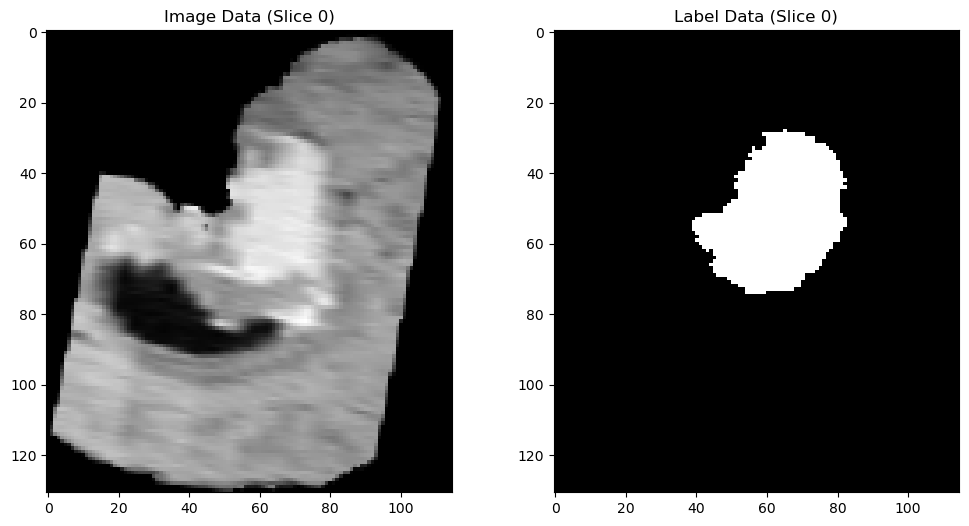

In [6]:
path = '/home/cansu/SSLCAT/SSLesion/data/BraTS2019/data/BraTS19_2013_0_1.h5'
import h5py
with h5py.File(path, 'r') as f:
    image_data = f['image'][:]
    label_data = f['label'][:]
print(image_data.shape, label_data.shape)
from matplotlib import pyplot as plt    
# make a subfigure 
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Display the image data
s = 60
axes[0].imshow(image_data[:, :, s ], cmap='gray')
axes[0].set_title('Image Data (Slice 0)')
# Display the label data
axes[1].imshow(label_data[:, :, s], cmap='gray')
axes[1].set_title('Label Data (Slice 0)')
# Show the plot
plt.show()

In [8]:
import numpy as np
np.unique(label_data)

array([0, 1], dtype=int16)

Create dataset for Mbhseg24

In [7]:
import os
mbhseg_path = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/MBHSeg24"
images_path = os.path.join(mbhseg_path, "images")
gts_path = os.path.join(mbhseg_path, "ground_truths")
unlabeled_imgs = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/MBHSeg24/unlabel_1980/unlabel_2000/anybleed"

# 1. rename all for the nnunet format
# 2. create labeled and unlabeled json files
# 3. create dataset.json file. 

dataset_path = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/nnUNet_raw/Dataset200_Mbhseg24"
# create the necessary directories
train_image_dir = os.path.join(dataset_path,'imagesTr')
train_label_dir = os.path.join(dataset_path,'labelsTr')
test_dir = os.path.join(dataset_path,'imagesTs')
test_dir_gt = os.path.join(dataset_path,'labelsTs')
os.makedirs(train_image_dir, exist_ok = True)
os.makedirs(train_label_dir, exist_ok = True)
os.makedirs(test_dir, exist_ok = True)
os.makedirs(test_dir_gt, exist_ok = True)

# we will first only do one fold. train and val. and the test set will be a seperated set from the beginning. 

# our train - val and test splits. 
# randomly draw 40 samples for the test set. (this is seperated form the beginning).

test_path = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/splits/mbhseg24/fold_0/test.txt"
val_path = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/splits/mbhseg24/fold_0/val.txt"
train_path = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/splits/mbhseg24/fold_0/train.txt"

# read txts
with open(test_path, 'r') as f:
    test_cases = [line.strip() for line in f.readlines()]
with open(val_path, 'r') as f:
    val_cases = [line.strip() for line in f.readlines()]
with open(train_path, 'r') as f:
    train_cases = [line.strip() for line in f.readlines()]

all_cases = train_cases + val_cases + test_cases

# now mix them and randomly draw 40 of them as a test set. 
print(f"Number of training cases: {len(all_cases)}")

# mix these 192 cases
import random
random.seed(42)
random.shuffle(all_cases)

test_cases = all_cases[:40]
train_val_cases = all_cases[40:]

print(f"Number of training+val cases: {len(train_val_cases)}")
print(f"Number of test cases: {len(test_cases)}")

# save the seperated test set as txt file
seperated_test_txt = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/splits/mbhseg24/seperated_test_set.txt"
with open(seperated_test_txt, 'w') as f:
    for case in test_cases:
        f.write(f"{case}\n")

FileNotFoundError: [Errno 2] No such file or directory: '/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/splits/mbhseg24/fold_0/test.txt'

In [8]:
# save the seperated test set as txt file
seperated_test_txt = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/splits/mbhseg24/seperated_test_set.txt"
with open(seperated_test_txt, 'w') as f:
    for case in test_cases:
        f.write(f"{case}\n")

In [10]:
# create 5 fold CV 

import os
from sklearn.model_selection import KFold

# Your cases
train_val_cases = list(train_val_cases)  # ensure it's a list
n_folds = 5
seed = 42

# Output directory
output_dir = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/splits/mbhseg24"
os.makedirs(output_dir, exist_ok=True)

kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

for fold, (train_idx, val_idx) in enumerate(kf.split(train_val_cases)):
    train_cases = [train_val_cases[i] for i in train_idx]
    val_cases = [train_val_cases[i] for i in val_idx]

    # File paths
    train_file = os.path.join(output_dir, f"fold_{fold}_train.txt")
    val_file = os.path.join(output_dir, f"fold_{fold}_val.txt")

    # Save train cases
    with open(train_file, "w") as f:
        for case in train_cases:
            f.write(f"{case}\n")

    # Save val cases
    with open(val_file, "w") as f:
        for case in val_cases:
            f.write(f"{case}\n")

    print(f"Fold {fold}: train={len(train_cases)}, val={len(val_cases)}")


Fold 0: train=121, val=31
Fold 1: train=121, val=31
Fold 2: train=122, val=30
Fold 3: train=122, val=30
Fold 4: train=122, val=30


In [1]:
# saglaması

fold_0_train = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/splits/mbhseg24/fold_0_train.txt"
fold_0_val = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/splits/mbhseg24/fold_0_val.txt"
seperated_test_txt = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/splits/mbhseg24/seperated_test_set.txt"

# read them all 

with open(fold_0_train, 'r') as f:
    fold_0_train_cases = [line.strip() for line in f.readlines()]
with open(fold_0_val, 'r') as f:
    fold_0_val_cases = [line.strip() for line in f.readlines()]
with open(seperated_test_txt, 'r') as f:
    seperated_test_cases = [line.strip() for line in f.readlines()]

print(f"Fold 0 - Train cases: {len(fold_0_train_cases)}")
print(f"Fold 0 - Val cases: {len(fold_0_val_cases)}")
print(f"Seperated Test cases: {len(seperated_test_cases)}") 
print("total cases:", len(fold_0_train_cases) + len(fold_0_val_cases) + len(seperated_test_cases))

Fold 0 - Train cases: 121
Fold 0 - Val cases: 31
Seperated Test cases: 40
total cases: 192


In [ ]:
# mbhseg 2025 data

test = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/splits/mbhseg25/fold_0/test.txt" 
train = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/splits/mbhseg25/fold_0/train.txt"
val = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/splits/mbhseg25/fold_0/val.txt"

# read them all
with open(test, 'r') as f:
    test_cases = [line.strip() for line in f.readlines()]
with open(train, 'r') as f:
    train_cases = [line.strip() for line in f.readlines()]
with open(val, 'r') as f:
    val_cases = [line.strip() for line in f.readlines()]

print(f"Train cases: {len(train_cases)}")
print(f"Val cases: {len(val_cases)}")
print(f"Test cases: {len(test_cases)}")
print("total cases:", len(train_cases) + len(val_cases) + len(test_cases))

# since 2024 and 2025 data are the same, we will use the same train val and seperate test set split for 2025 data.

Train cases: 123
Val cases: 30
Test cases: 39
total cases: 192


Renaming and copy and pasting the data in nnunet format

In [5]:
# read the train, val, and test text files

train_file = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/splits/mbhseg24/fold_0_train.txt"
val_file = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/splits/mbhseg24/fold_0_val.txt"
test_file = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/splits/mbhseg24/seperated_test_set.txt"

with open(train_file, 'r') as f:
    train_cases = [line.strip() for line in f.readlines()]
with open(val_file, 'r') as f:
    val_cases = [line.strip() for line in f.readlines()]
with open(test_file, 'r') as f:
    test_cases = [line.strip() for line in f.readlines()]

print(f"Number of training cases: {len(train_cases)}")
print(f"Number of validation cases: {len(val_cases)}")
print(f"Number of test cases: {len(test_cases)}")

Number of training cases: 121
Number of validation cases: 31
Number of test cases: 40


Creating the splits and trainset dictionaries

In [16]:
mbhseg_images = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/MBHSeg24/images"
gts_path = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/MBHSeg24/ground_truths"

import os 
import shutil
import numpy as np
import json

imagetr_dir = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/nnUNet_raw/Dataset200_Mbhseg24/imagesTr"
labelsTr = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/nnUNet_raw/Dataset200_Mbhseg24/labelsTr"
imagesTs = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/nnUNet_raw/Dataset200_Mbhseg24/imagesTs"
labelsTs = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/nnUNet_raw/Dataset200_Mbhseg24/labelsTs"

trainval_set = train_cases + val_cases # total 152 cases. 

count = 0
dict_names_train = {}
for case in trainval_set:

    # make a 3 digit case id
    case_id = str(count).zfill(3)

    orig_image_path = os.path.join(mbhseg_images, f"{case}.nii.gz")
    dest_image_path = os.path.join(imagetr_dir, f"mbhseg_{case_id}_0000.nii.gz")
    orig_gt_path = os.path.join(gts_path, f"{case}.nii.gz")
    dest_gt_path = os.path.join(labelsTr, f"mbhseg_{case_id}.nii.gz")

    # save the name matching 
    dict_names_train[f"mbhseg_{case_id}_0000"] = case
    count += 1

    shutil.copy(orig_image_path, dest_image_path)
    shutil.copy(orig_gt_path, dest_gt_path)

# save the dictionary to a JSON file
dataset_path = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/nnUNet_raw/Dataset200_Mbhseg24"
json_path = os.path.join(dataset_path, 'dict_names_trainval.json')
with open(json_path, 'w') as json_file:
    json.dump(dict_names_train, json_file, indent=4)

In [18]:
mbhseg_images = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/MBHSeg24/images"
gts_path = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/MBHSeg24/ground_truths"

import os 
import shutil
import numpy as np
import json

imagesTs = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/nnUNet_raw/Dataset200_Mbhseg24/imagesTs"
labelsTs = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/nnUNet_raw/Dataset200_Mbhseg24/labelsTs" 

# start count from the last number of trainval set
count = len(trainval_set)
dict_names_test = {}
for case in test_cases:

    # make a 3 digit case id
    case_id = str(count).zfill(3)

    orig_image_path = os.path.join(mbhseg_images, f"{case}.nii.gz")
    dest_image_path = os.path.join(imagesTs, f"mbhseg_{case_id}_0000.nii.gz")
    orig_gt_path = os.path.join(gts_path, f"{case}.nii.gz")
    dest_gt_path = os.path.join(labelsTs, f"mbhseg_{case_id}.nii.gz")

    # save the name matching 
    dict_names_test[f"mbhseg_{case_id}_0000"] = case
    count += 1

    shutil.copy(orig_image_path, dest_image_path)
    shutil.copy(orig_gt_path, dest_gt_path)

# save the dictionary to a JSON file
dataset_path = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/nnUNet_raw/Dataset200_Mbhseg24"
json_path = os.path.join(dataset_path, 'dict_names_test.json')
with open(json_path, 'w') as json_file:
    json.dump(dict_names_test, json_file, indent=4)

Change the naming for the mbhseg 2925 data as well 

In [8]:
# read the train, val, and test text files

train_file = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/splits/mbhseg25/fold_0_train.txt"
val_file = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/splits/mbhseg25/fold_0_val.txt"
test_file = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/splits/mbhseg25/seperated_test_set.txt"

with open(train_file, 'r') as f:
    train_cases = [line.strip() for line in f.readlines()]
with open(val_file, 'r') as f:
    val_cases = [line.strip() for line in f.readlines()]
with open(test_file, 'r') as f:
    test_cases = [line.strip() for line in f.readlines()]

print(f"Number of training cases: {len(train_cases)}")
print(f"Number of validation cases: {len(val_cases)}")
print(f"Number of test cases: {len(test_cases)}")

Number of training cases: 121
Number of validation cases: 31
Number of test cases: 40


In [9]:
# # # mv_images = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/MBHSeg25/Majority_voting/images"

# # # #count how many files are in the mv_images folder
# # # num_files = len(os.listdir(mv_images))
# # # print(f"Number of files in the Majority_voting images folder: {num_files}")

# # # #save all the cases into an array
# # # all_cases = os.listdir(mv_images)

# # # all_cases_mbhseg24 = train_cases + val_cases + test_cases

# # # # compare the two lists and find which cases are different
# # # different_cases = set(all_cases) - set([f"{case}.nii.gz" for case in all_cases_mbhseg24])
# # # print(f"Different cases between MBHSeg24 and Majority_voting images: {different_cases}")

# # # # since some of the naming is different, we can create another train, val, test split for the majority voting data.

all_cases = train_cases + val_cases + test_cases

import random
random.seed(42)
random.shuffle(all_cases)

mbhseg25_test_cases = all_cases[:40]
mbhseg_25_train_val_cases = all_cases[40:]    
print(f"Number of training+val cases: {len(mbhseg_25_train_val_cases)}")
print(f"Number of test cases: {len(mbhseg25_test_cases)}")
# save the seperated test set as txt file
seperated_test_txt = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/splits/mbhseg25/seperated_test_set.txt"
with open(seperated_test_txt, 'w') as f:
    for case in mbhseg25_test_cases:
        case_name = case.replace('.nii.gz', '')
        f.write(f"{case_name}\n")
# create 5 fold CV
import os
from sklearn.model_selection import KFold
# Your cases
mbhseg_25_train_val_cases = list(mbhseg_25_train_val_cases)  # ensure it's a list
n_folds = 5
seed = 42   
# Output directory
output_dir = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/splits/mbhseg25"
os.makedirs(output_dir, exist_ok=True)
kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
for fold, (train_idx, val_idx) in enumerate(kf.split(mbhseg_25_train_val_cases)):
    train_cases = [mbhseg_25_train_val_cases[i] for i in train_idx]
    val_cases = [mbhseg_25_train_val_cases[i] for i in val_idx]
    # File paths
    train_file = os.path.join(output_dir, f"fold_{fold}_train.txt")
    val_file = os.path.join(output_dir, f"fold_{fold}_val.txt")
    # Save train cases
    with open(train_file, "w") as f:
        for case in train_cases:
            case_name = case.replace('.nii.gz', '')
            f.write(f"{case_name}\n")
    # Save val cases
    with open(val_file, "w") as f:
        for case in val_cases:
            case_name = case.replace('.nii.gz', '')
            f.write(f"{case_name}\n")
    print(f"Fold {fold}: train={len(train_cases)}, val={len(val_cases)}")

Number of training+val cases: 152
Number of test cases: 40
Fold 0: train=121, val=31
Fold 1: train=121, val=31
Fold 2: train=122, val=30
Fold 3: train=122, val=30
Fold 4: train=122, val=30


In [10]:
mbhseg_images = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/MBHSeg25/Majority_voting/images"
gts_path = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/MBHSeg25/Majority_voting/ground_truths"

import os 
import shutil
import numpy as np
import json

imagetr_dir = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/nnUNet_raw/Dataset300_Mbhseg25/imagesTr"
labelsTr = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/nnUNet_raw/Dataset300_Mbhseg25/labelsTr"
imagesTs = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/nnUNet_raw/Dataset300_Mbhseg25/imagesTs"
labelsTs = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/nnUNet_raw/Dataset300_Mbhseg25/labelsTs"

# create directories if not exist
os.makedirs(imagetr_dir, exist_ok = True)
os.makedirs(labelsTr, exist_ok = True)
os.makedirs(imagesTs, exist_ok = True)
os.makedirs(labelsTs, exist_ok = True)

count = 0
dict_names_train = {}
for case in mbhseg_25_train_val_cases:

    # make a 3 digit case id
    case_id = str(count).zfill(3)

    orig_image_path = os.path.join(mbhseg_images, f"{case}.nii.gz")
    dest_image_path = os.path.join(imagetr_dir, f"mbhseg_{case_id}_0000.nii.gz")
    orig_gt_path = os.path.join(gts_path, f"{case}.nii.gz")
    dest_gt_path = os.path.join(labelsTr, f"mbhseg_{case_id}.nii.gz")

    # save the name matching 
    dict_names_train[f"mbhseg_{case_id}_0000"] = case
    count += 1

    shutil.copy(orig_image_path, dest_image_path)
    shutil.copy(orig_gt_path, dest_gt_path)

# save the dictionary to a JSON file
dataset_path = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/nnUNet_raw/Dataset300_Mbhseg25"
json_path = os.path.join(dataset_path, 'dict_names_trainval.json')
with open(json_path, 'w') as json_file:
    json.dump(dict_names_train, json_file, indent=4)

In [11]:
mbhseg_images = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/MBHSeg25/Majority_voting/images"
gts_path = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/MBHSeg25/Majority_voting/ground_truths"

import os 
import shutil
import numpy as np
import json

imagesTs = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/nnUNet_raw/Dataset300_Mbhseg25/imagesTs"
labelsTs = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/nnUNet_raw/Dataset300_Mbhseg25/labelsTs" 

# start count from the last number of trainval set
count = len(mbhseg_25_train_val_cases)
dict_names_test = {}
for case in mbhseg25_test_cases:

    # make a 3 digit case id
    case_id = str(count).zfill(3)

    orig_image_path = os.path.join(mbhseg_images, f"{case}.nii.gz")
    dest_image_path = os.path.join(imagesTs, f"mbhseg_{case_id}_0000.nii.gz")
    orig_gt_path = os.path.join(gts_path, f"{case}.nii.gz")
    dest_gt_path = os.path.join(labelsTs, f"mbhseg_{case_id}.nii.gz")

    # save the name matching 
    dict_names_test[f"mbhseg_{case_id}_0000"] = case
    count += 1

    shutil.copy(orig_image_path, dest_image_path)
    shutil.copy(orig_gt_path, dest_gt_path)

# save the dictionary to a JSON file
dataset_path = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/nnUNet_raw/Dataset300_Mbhseg25"
json_path = os.path.join(dataset_path, 'dict_names_test.json')
with open(json_path, 'w') as json_file:
    json.dump(dict_names_test, json_file, indent=4)

# Create labeled and unlabeled splits for the mbhseg24 25 datasets

In [39]:
# we will create 10% and 20% labeled data splits from the training data

fold_0_train = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/splits/mbhseg25/fold_0_train.txt"
with open(fold_0_train, 'r') as f:
    fold_0_train_cases = [line.strip() for line in f.readlines()]
fold_0_val = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/splits/mbhseg25/fold_0_val.txt"
with open(fold_0_val, 'r') as f:
    fold_0_val_cases = [line.strip() for line in f.readlines()]

mbhgseg24_train_val_names = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/nnUNet_raw/Dataset200_Mbhseg24/dict_names_trainval.json"
with open(mbhgseg24_train_val_names, 'r') as f:
    mbhgseg24_train_val_dict = json.load(f)

# create 10% and 20% labeled data splits, put them in json files with keys as nnunet names and values as original names
num_total = len(fold_0_train_cases)
num_10_percent = int(0.1 * num_total)
num_20_percent = int(0.2 * num_total)
num_100_percent = int(1.0 * num_total)
random.seed(42)

train_cases_10_percent = random.sample(fold_0_train_cases, num_10_percent)
train_cases_20_percent = random.sample(fold_0_train_cases, num_20_percent)
train_cases_100_percent = fold_0_train_cases  # all cases

# rest of the unlabeled data 
train_cases_10_percent_unlabeled = list(set(fold_0_train_cases) - set(train_cases_10_percent))
train_cases_20_percent_unlabeled = list(set(fold_0_train_cases) - set(train_cases_20_percent))  

dict_10_percent = {}
dict_20_percent = {}
dict_100_percent = {}
dict_10_percent_unlabeled = {}
dict_20_percent_unlabeled = {}

for case in train_cases_10_percent:
    for nnunet_name, original_name in mbhgseg24_train_val_dict.items():
        if original_name == case:
            dict_10_percent[nnunet_name] = original_name
            break

for case in train_cases_20_percent:
    for nnunet_name, original_name in mbhgseg24_train_val_dict.items():
        if original_name == case:
            dict_20_percent[nnunet_name] = original_name
            break


for case in train_cases_100_percent:
    for nnunet_name, original_name in mbhgseg24_train_val_dict.items():
        if original_name == case:
            dict_100_percent[nnunet_name] = original_name
            break

for case in train_cases_10_percent_unlabeled:
    for nnunet_name, original_name in mbhgseg24_train_val_dict.items():
        if original_name == case:
            dict_10_percent_unlabeled[nnunet_name] = original_name
            break

for case in train_cases_20_percent_unlabeled:
    for nnunet_name, original_name in mbhgseg24_train_val_dict.items():
        if original_name == case:
            dict_20_percent_unlabeled[nnunet_name] = original_name
            break

# save the dictionaries to JSON files
json_10_percent_path = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/all_splits_trainset/10_labeled_mbhseg24_fold0.json"
with open(json_10_percent_path, 'w') as json_file:
    json.dump(dict_10_percent, json_file, indent=4)

json_20_percent_path = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/all_splits_trainset/20_labeled_mbhseg24_fold0.json"
with open(json_20_percent_path, 'w') as json_file:
    json.dump(dict_20_percent, json_file, indent=4)

json_100_percent_path = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/all_splits_trainset/100_labeled_mbhseg24_fold0.json"
with open(json_100_percent_path, 'w') as json_file:
    json.dump(dict_100_percent, json_file, indent=4)

json_10_percent_unlabeled_path = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/all_splits_trainset/10_unlabeled_mbhseg24_fold0.json"
with open(json_10_percent_unlabeled_path, 'w') as json_file:
    json.dump(dict_10_percent_unlabeled, json_file, indent=4)

json_20_percent_unlabeled_path = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/all_splits_trainset/20_unlabeled_mbhseg24_fold0.json"
with open(json_20_percent_unlabeled_path, 'w') as json_file:
    json.dump(dict_20_percent_unlabeled, json_file, indent=4)

In [41]:
from collections import OrderedDict

dataset_name = 'Dataset200_Mbhseg24'
nnunet_basedir = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet" 
nnunet_dataset = os.path.join(nnunet_basedir, 'data/nnUNet_raw/', dataset_name)
train_image_dir = os.path.join(nnunet_dataset,'imagesTr')
train_label_dir = os.path.join(nnunet_dataset,'labelsTr')
test_dir = os.path.join(nnunet_dataset,'imagesTs')

dataset_json_path = os.path.join(nnunet_dataset, 'dataset.json')
overwrite_json_file = True  #make it True if you want to overwrite the dataset.json file in Task_folder
json_file_exist = False

if os.path.exists(dataset_json_path):
    print('dataset.json already exist!')
    json_file_exist = True

if json_file_exist==False or overwrite_json_file:
    json_dict = OrderedDict()
    json_dict['dataset_name'] = dataset_name
    json_dict['description'] = "Mbhseg24 dataset multi-class segmentation task"
    json_dict['tensor_image_size'] = "3D"
    json_dict['file_ending'] = ".nii.gz"

    #you may mention more than one modality (it is important, as it may affect the intensity normalization type, for ex: CT vs T1w)
    json_dict['channel_names'] = {
        "0": "CT"
    }

    #labels+1 should be mentioned for all the labels in the dataset
    json_dict['labels'] = {
        "background": 0,
        "edh" : 1,
        "iph" : 2,
        "ivh" : 3,
        "sdh" : 4,
        "sah" : 5
    }

    train_ids = sorted(os.listdir(train_label_dir))
    test_ids = sorted(os.listdir(test_dir))
    json_dict['numTraining'] = len(train_ids)
    json_dict['numTesting'] = len(test_ids)

    # no modality in train image and labels in dataset.json 
    json_dict['training'] = [{'image': "./imagesTr/%s" % i, "label": "./labelsTr/%s" % i} for i in train_ids]

    # removing the modality from test image name to be saved in dataset.json
    json_dict['test'] = ["./imagesTs/%s" % i for i in test_ids]

    with open(dataset_json_path, 'w') as f:
        json.dump(json_dict, f, indent=4, sort_keys=True)

    if os.path.exists(dataset_json_path):
        if json_file_exist==False:
            print('dataset.json created!')
        else: 
            print('dataset.json overwritten!')

dataset.json created!


In [12]:
# we will create 10% and 20% labeled data splits from the training data

fold_0_train = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/splits/mbhseg25/fold_0_train.txt"
with open(fold_0_train, 'r') as f:
    fold_0_train_cases = [line.strip() for line in f.readlines()]
fold_0_val = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/splits/mbhseg25/fold_0_val.txt"
with open(fold_0_val, 'r') as f:
    fold_0_val_cases = [line.strip() for line in f.readlines()]

mbhgseg24_train_val_names = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/nnUNet_raw/Dataset300_Mbhseg25/dict_names_trainval.json"
with open(mbhgseg24_train_val_names, 'r') as f:
    mbhgseg24_train_val_dict = json.load(f)

# create 10% and 20% labeled data splits, put them in json files with keys as nnunet names and values as original names
num_total = len(fold_0_train_cases)
num_10_percent = int(0.1 * num_total)
num_20_percent = int(0.2 * num_total)
num_100_percent = int(1.0 * num_total)
random.seed(42)

train_cases_10_percent = random.sample(fold_0_train_cases, num_10_percent)
train_cases_20_percent = random.sample(fold_0_train_cases, num_20_percent)
train_cases_100_percent = fold_0_train_cases  # all cases

# rest of the unlabeled data 
train_cases_10_percent_unlabeled = list(set(fold_0_train_cases) - set(train_cases_10_percent))
train_cases_20_percent_unlabeled = list(set(fold_0_train_cases) - set(train_cases_20_percent))  

dict_10_percent = {}
dict_20_percent = {}
dict_100_percent = {}
dict_10_percent_unlabeled = {}
dict_20_percent_unlabeled = {}

for case in train_cases_10_percent:
    for nnunet_name, original_name in mbhgseg24_train_val_dict.items():
        if original_name == case:
            dict_10_percent[nnunet_name] = original_name
            break

for case in train_cases_20_percent:
    for nnunet_name, original_name in mbhgseg24_train_val_dict.items():
        if original_name == case:
            dict_20_percent[nnunet_name] = original_name
            break


for case in train_cases_100_percent:
    for nnunet_name, original_name in mbhgseg24_train_val_dict.items():
        if original_name == case:
            dict_100_percent[nnunet_name] = original_name
            break

for case in train_cases_10_percent_unlabeled:
    for nnunet_name, original_name in mbhgseg24_train_val_dict.items():
        if original_name == case:
            dict_10_percent_unlabeled[nnunet_name] = original_name
            break

for case in train_cases_20_percent_unlabeled:
    for nnunet_name, original_name in mbhgseg24_train_val_dict.items():
        if original_name == case:
            dict_20_percent_unlabeled[nnunet_name] = original_name
            break

# save the dictionaries to JSON files
json_10_percent_path = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/all_splits_trainset/10_labeled_mbhseg25_fold0.json"
with open(json_10_percent_path, 'w') as json_file:
    json.dump(dict_10_percent, json_file, indent=4)

json_20_percent_path = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/all_splits_trainset/20_labeled_mbhseg25_fold0.json"
with open(json_20_percent_path, 'w') as json_file:
    json.dump(dict_20_percent, json_file, indent=4)

json_100_percent_path = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/all_splits_trainset/100_labeled_mbhseg25_fold0.json"
with open(json_100_percent_path, 'w') as json_file:
    json.dump(dict_100_percent, json_file, indent=4)

json_10_percent_unlabeled_path = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/all_splits_trainset/10_unlabeled_mbhseg25_fold0.json"
with open(json_10_percent_unlabeled_path, 'w') as json_file:
    json.dump(dict_10_percent_unlabeled, json_file, indent=4)

json_20_percent_unlabeled_path = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet/data/all_splits_trainset/20_unlabeled_mbhseg25_fold0.json"
with open(json_20_percent_unlabeled_path, 'w') as json_file:
    json.dump(dict_20_percent_unlabeled, json_file, indent=4)

In [13]:
from collections import OrderedDict
import os
import json

dataset_name = 'Dataset300_Mbhseg25'
nnunet_basedir = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/code/nnUNet" 
nnunet_dataset = os.path.join(nnunet_basedir, 'data/nnUNet_raw/', dataset_name)
train_image_dir = os.path.join(nnunet_dataset,'imagesTr')
train_label_dir = os.path.join(nnunet_dataset,'labelsTr')
test_dir = os.path.join(nnunet_dataset,'imagesTs')

dataset_json_path = os.path.join(nnunet_dataset, 'dataset.json')
overwrite_json_file = True  #make it True if you want to overwrite the dataset.json file in Task_folder
json_file_exist = False

if os.path.exists(dataset_json_path):
    print('dataset.json already exist!')
    json_file_exist = True

if json_file_exist==False or overwrite_json_file:
    json_dict = OrderedDict()
    json_dict['dataset_name'] = dataset_name
    json_dict['description'] = "Mbhseg25 dataset multi-class segmentation task"
    json_dict['tensor_image_size'] = "3D"
    json_dict['file_ending'] = ".nii.gz"

    #you may mention more than one modality (it is important, as it may affect the intensity normalization type, for ex: CT vs T1w)
    json_dict['channel_names'] = {
        "0": "CT"
    }

    #labels+1 should be mentioned for all the labels in the dataset
    json_dict['labels'] = {
        "background": 0,
        "edh" : 1,
        "iph" : 2,
        "ivh" : 3,
        "sdh" : 4,
        "sah" : 5
    }

    train_ids = sorted(os.listdir(train_label_dir))
    test_ids = sorted(os.listdir(test_dir))
    json_dict['numTraining'] = len(train_ids)
    json_dict['numTesting'] = len(test_ids)

    # no modality in train image and labels in dataset.json 
    json_dict['training'] = [{'image': "./imagesTr/%s" % i, "label": "./labelsTr/%s" % i} for i in train_ids]

    # removing the modality from test image name to be saved in dataset.json
    json_dict['test'] = ["./imagesTs/%s" % i for i in test_ids]

    with open(dataset_json_path, 'w') as f:
        json.dump(json_dict, f, indent=4, sort_keys=True)

    if os.path.exists(dataset_json_path):
        if json_file_exist==False:
            print('dataset.json created!')
        else: 
            print('dataset.json overwritten!')

dataset.json already exist!
dataset.json overwritten!


# create majority voting labels

In [4]:
import os
import numpy as np
import nibabel as nib
from collections import Counter

# if there is a tie, assign background label (0).

all_data_mbhseg25 = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/MBHSeg25/MBH_Train_2025_voxel-label"

for folder in sorted(os.listdir(all_data_mbhseg25)):
    folder_path = os.path.join(all_data_mbhseg25, folder)

    if not os.path.isdir(folder_path):
        continue

    image_path = os.path.join(folder_path, "image.nii.gz")
    if not os.path.exists(image_path):
        continue

    # find all annotator labels
    label_files = sorted([
        f for f in os.listdir(folder_path)
        if f.startswith("label_annot_") and f.endswith(".nii.gz")
    ])

    if len(label_files) < 2:
        print(f"Skipping {folder}: less than 2 annotations")
        continue

    # load labels
    label_arrays = []
    for lf in label_files:
        lbl_nii = nib.load(os.path.join(folder_path, lf))
        label_arrays.append(lbl_nii.get_fdata().astype(np.int16))

    label_arrays = np.stack(label_arrays, axis=0)  # (N_annot, H, W, D)

    # output array
    majority_label = np.zeros(label_arrays.shape[1:], dtype=np.int16)

    # flatten for easier iteration
    flat_labels = label_arrays.reshape(label_arrays.shape[0], -1)

    for idx in range(flat_labels.shape[1]):
        votes = flat_labels[:, idx]
        vote_count = Counter(votes)

        most_common = vote_count.most_common()

        if len(most_common) == 1:
            majority_label.flat[idx] = most_common[0][0]
        else:
            # check for tie
            if most_common[0][1] == most_common[1][1]:
                majority_label.flat[idx] = 0  # background on tie
            else:
                majority_label.flat[idx] = most_common[0][0]

    # save majority-voted label
    out_nii = nib.Nifti1Image(
        majority_label,
        affine=lbl_nii.affine,
        header=lbl_nii.header
    )

    out_path = os.path.join("/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/MBHSeg25/Majority_voting/ground_truths", f"{folder}.nii.gz")
    nib.save(out_nii, out_path)

    print(f"Saved majority label for {folder} ({len(label_files)} annotators)")


Saved majority label for ID_0237f3c9_ID_40015688b9 (2 annotators)
Saved majority label for ID_029ebbea_ID_563afa0901 (3 annotators)
Saved majority label for ID_02b882cc_ID_a4892e60ae (2 annotators)
Saved majority label for ID_02f779fb_ID_c4d7f33559 (2 annotators)
Saved majority label for ID_041e6601_ID_1fa1d20bba (2 annotators)
Saved majority label for ID_0492041f_ID_b4fcf2f799 (3 annotators)
Saved majority label for ID_05331dc6_ID_47213b7e2e (3 annotators)
Saved majority label for ID_07365cde_ID_8e661b8f07 (2 annotators)
Saved majority label for ID_089596a9_ID_ea71b57820 (2 annotators)
Saved majority label for ID_09b33fc4_ID_bcd322d4ed (2 annotators)
Saved majority label for ID_0b10cbee_ID_f91d6a7cd2 (3 annotators)
Saved majority label for ID_0c3eef60_ID_6994ad7df0 (3 annotators)
Saved majority label for ID_0c6b97a9_ID_6011bb9ce8 (3 annotators)
Saved majority label for ID_10beb45f_ID_7184e80f09 (3 annotators)
Saved majority label for ID_10c64d22_ID_4c9aad31ca (2 annotators)
Saved majo

In [6]:
# saglaması
img_1 = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/MBHSeg25/Majority_voting/images/ID_0c3eef60_ID_6994ad7df0.nii.gz"
gt_1 = "/media/cansu/DiskSpace/Cansu/Benchmarking-MBHSeg/data/MBHSeg25/Majority_voting/ground_truths/ID_0c3eef60_ID_6994ad7df0.nii.gz"

i = nib.load(img_1)
g = nib.load(gt_1)

print("Image shape:", i.shape)
print("GT shape:", g.shape)
print("Unique labels in GT:", np.unique(g.get_fdata()))

Image shape: (512, 512, 35)
GT shape: (512, 512, 35)
Unique labels in GT: [0. 2.]
